This code is to fit a spectrum as the sum of two models, and really it's a sum of four models. 

The goal is to map out the space of possible delta-Teff and spot coverage fractions allowed.
I suspect I will have to run this with a prior on either delta-Teff or fS to get something meaningful because of degeneracies

To do:
<br /> -Test with models against models
<br /> -Read in observed spectra of K2-33
<br /> -Test LkCa 4 (if we have a spectrum)?
<br /> -Down-sample and smooth models to match data
<br /> -Test with fS = 0

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy import stats
import numpy.random as random
from scipy import optimize
import emcee
import corner
import random

import multiprocessing as mp
Pool = mp.get_context('fork').Pool
from dust_extinction.parameter_averages import F19
# define the model
ext = F19(Rv=3.1)

In [2]:
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

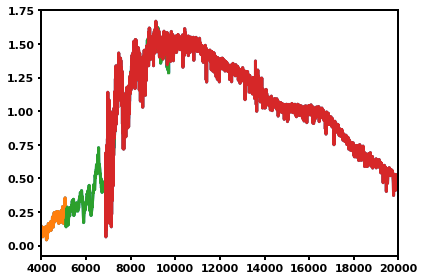

(8517,)


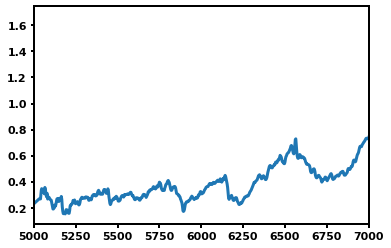

In [3]:
## read in data
obswav,obsspec,obserr,obstype = np.loadtxt('rawspec.txt',unpack=True,skiprows=1)

plt.plot(obswav,obsspec)
l1 = np.where(obstype == 1)
plt.plot(obswav[l1],obsspec[l1])
l2 = np.where(obstype == 2)
plt.plot(obswav[l2],obsspec[l2])
l3 = np.where(obstype == 3)
plt.plot(obswav[l3],obsspec[l3])
plt.xlim(4000,20000)
plt.tight_layout()
plt.show()

#l4 = np.where(((obstype ==1)| (obstype ==2)) & (obswav > 4000))
l4 = np.where((obswav > 4000) & (obswav<24000) & ((obswav > 8000)|(obstype<3)) & (obsspec > 0))
opticalspec = obsspec[l4]
opticalwav = obswav[l4]
opticalerr = obserr[l4]
l5 = np.where((obswav > 4000) & (obswav<23500) & (obsspec/obserr > 10))
#l5 = np.where((obswav > 4000) & (obswav<23500) & (obsspec/obserr > 15) & ((obswav > 6600)|(obswav<6300)))
obsspec_cut = np.array(obsspec[l5])
obswav_cut = np.array(obswav[l5])
obserr_cut = np.array(obserr[l5])
obstype_cut = np.array(obstype[l5])

print(np.shape(obswav_cut))
plt.plot(obswav_cut,obsspec_cut)
plt.tight_layout
plt.xlim(5000,7000)
plt.show()

In [14]:
#modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits'
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data

#print(np.min(data['teff']),np.max(data['teff']))
#print(data['header'])

## trim the models to just solar metallicity 
teff = np.squeeze(data['teff'])
logg = np.squeeze(data['logg'])
afe = np.squeeze(data['a_fe'])
mh = np.squeeze(data['metal'])
spectra = np.squeeze(data['spectrum'])

loc = np.where((logg == 4.5) & (mh == 0) & (teff > 1000) & (afe == 0))
modelteff = teff[loc]
modelspectra = np.squeeze(spectra[:,loc])
lambda0 = 1000
nlambda = 149501
dlambda = 2
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
ll = np.where((modelwave > 3000) & (modelwave < 53000))
#print(np.shape(ll))
modelspectra = np.squeeze(modelspectra[ll,:])
modelwave = modelwave[ll]
#print(np.shape(modelteff),np.shape(modelspectra),np.shape(modelwave))
#print(np.max(modelteff),np.min(modelteff))

## resample model spectra
from gaussfold import gaussfold as gf
newlambda = np.array(obswav_cut)
newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = np.array(modelspectra[:,i])
    interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc(newlambda)
    modelspec_new = gf(newlambda, modelspec_new, 5)
    newmodel[:,i] = modelspec_new

modelwave = newlambda
modelspectra = newmodel

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 44252296E, 296E, 296E, 296E, 296E, 296E]   


In [15]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    #print(inteff,np.shape(spectra),np.shape(teffs))
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

In [24]:
## the likelihood needs to fit a few parameters:
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets
## 4) flux calibration errors?
## 5) fS
## 6) ??
#define functions for MCMC
def ln_prior(theta):
    Tsurf, Tspot, fS, a, b, c, AV, loff, f = theta
    if AV > 2 or AV < 0.3 or (loff < -3) or (loff > 3) or (Tspot < 1500) or (Tspot > 3900) or (Tsurf < 1500) or (Tsurf > 3900) or fS < 0.0 or fS > 1.0 or f < 0 or f > 1 or Tspot>(Tsurf-200):
        return -np.inf
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    Tsurf, Tspot, fS, a, b, c, AV, loff, f = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    modelspec_smooth = modelspec_shift  
    reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
        
    modelspec_norm = np.array(reddened)
    obsspec_norm = np.array(obsspec)
    obsspec_err_norm = np.array(obserr)
    obsspec_norm[np.where(obstype == 1)]*=a
    obsspec_norm[np.where(obstype == 2)]*=b
    obsspec_norm[np.where(obstype == 3)]*=c
    obsspec_err_norm[np.where(obstype == 1)]*=a
    obsspec_err_norm[np.where(obstype == 2)]*=b
    obsspec_err_norm[np.where(obstype == 3)]*=c    
    ## due to edge effects, we need to trim the first and last ~20 points
    
    diff = (modelspec_norm - obsspec_norm)
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    output = np.sum(np.log(p[20:np.size(modelspec_norm)-20]))
    return output

def ln_posterior(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

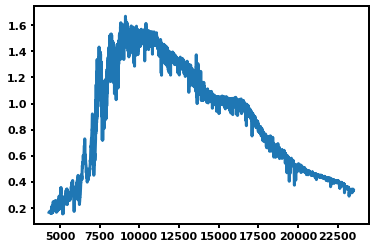

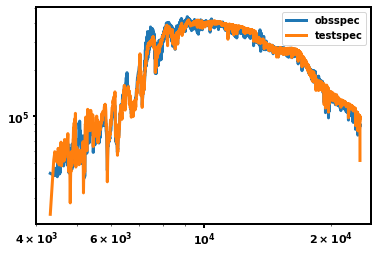

In [25]:
obsspec_cut = np.array(obsspec[l5])
obswav_cut = np.array(obswav[l5])
obserr_cut = np.array(obserr[l5])
obstype_cut = np.array(obstype[l5])
plt.plot(modelwave,obsspec_cut)
plt.show()
bluenorm, rednorm, irnorm = [294802.917,299787.751, 296800]
testspec = doublespec(modelteff,modelspectra,3540,2900,0.55)
red = ext.extinguish(modelwave*u.AA, Av=0.5)
testspec *= red
obsspec_plot = obsspec_cut/(np.median(obsspec_cut)/np.median(testspec))

plt.plot(modelwave,obsspec_plot,label='obsspec')
plt.plot(modelwave,testspec,label='testspec')
plt.xscale('log')
plt.yscale('log')
plt.xlim(4000,25000)
plt.legend()
plt.show()

In [26]:
nwalkers, ndim = 30, 9
nthreads = 12
ospec = np.array(list(obsspec_cut))
otype = np.array(list(obstype_cut))
oerr = np.array(list(obserr_cut))
mspec = np.array(list(modelspectra))
mteff = np.array(list(modelteff))
mwav = np.array(list(modelwave))

print('if this is inf, we have a problem:')
initial_guesses = [3611, 2500, 0.2, 298591, 280369, 285025, 0.56, -0.923, 0.05]
print(ln_posterior(initial_guesses,mteff,mspec,mwav,ospec,otype,oerr))

pos0 = []
print('initializing walkers: (if you see a lot if inf, break this)')
while len(pos0) < nwalkers:
    trial = initial_guesses + 0.1 * np.random.randn(ndim)
    lp = ln_posterior(trial,mteff,mspec,mwav,ospec,otype,oerr)
    print(lp)
    if np.isfinite(lp):
        pos0.append(trial)

if this is inf, we have a problem:
-245393.96411726874
initializing walkers: (if you see a lot if inf, break this)
-inf
-161237.12916767594
-inf
-inf
-127727.26949247345
-inf
-114523.96373953958
-inf
-inf
-116039.99582213484
-134814.56910366623
-154530.2364948114
-inf
-inf
-181774.35665473054
-inf
-328808.3056530416
-inf
-inf
-134080.77769025235
-166984.0302948905
-inf
-120940.91384151841
-inf
-139603.7056740266
-323255.0451315396
-169136.49128900337
-103114.23733989813
-inf
-196943.70676582155
-125758.61892887171
-inf
-inf
-inf
-145023.52606095336
-108210.4048398979
-142914.2722380437
-152058.16635971106
-inf
-136945.46121375563
-inf
-inf
-inf
-inf
-105077.10609035332
-inf
-inf
-inf
-225695.28098251595
-134063.7845000252
-inf
-109272.25298282277
-inf
-106731.35039844176
-inf
-108999.58451907909
-inf
-229054.45320225536
-117980.01713625653


/Users/andrewmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


In [ ]:
nsteps = 50000
burn = 10000
thin = 10

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(mteff,mspec,mwav,ospec,otype,oerr), threads=nthreads)
sampler.run_mcmc(pos0, nsteps,progress=True)

print('done')

  6%|▌         | 3077/50000 [02:56<44:12, 17.69it/s]  

In [ ]:
labels = ['Tsurf','Tspot','fS','a','b','c','Av','loff','f']
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.show()
plt.savefig('Walkers_specfit.pdf')

In [ ]:
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
print(flat_samples.shape)
fig = corner.corner( 
    flat_samples, labels=labels, show_titles=True,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec.pdf')


flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
trimmed_flat = flat_samples[:,0:3]
trimmed_labels = labels[0:3]
fig = corner.corner( 
    trimmed_flat, labels=trimmed_labels, show_titles=True,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.1f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec_trim.pdf')

In [ ]:
## report best-fit parameters
best = []
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    #if i == 0:
    #    mcmc = np.percentile(np.exp(flat_samples[:, i]), [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    best.append(mcmc[1])

print(best)

In [ ]:
mteff = modelteff
modelspectra = mspec
wav = np.array(mwav)
obsspec = np.array(ospec)
obstype = np.array(otype)
obserr = np.array(oerr)
Tsurf, Tspot, fS, a, b, c, AV, loff, f = best
modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
newwav = wav + loff
interpfunc = interpolate.interp1d(newwav, modelspec, kind='linear',fill_value="extrapolate")
modelspec_shift = interpfunc(wav)
modelspec_smooth = modelspec_shift  
reddened = modelspec_smooth*ext.extinguish(wav*u.AA, Av=AV)
    
#l = np.where(modelwave < 5200)
#reddened[l]/=a
modelspec_norm = np.array(reddened)
obsspec_norm = np.array(obsspec)
obsspec_err_norm = np.array(obserr)
obsspec_norm[np.where(obstype == 1)]*=a
obsspec_norm[np.where(obstype == 2)]*=b
obsspec_norm[np.where(obstype == 3)]*=c
obsspec_err_norm[np.where(obstype == 1)]*=a
obsspec_err_norm[np.where(obstype == 2)]*=b
obsspec_err_norm[np.where(obstype == 3)]*=c  

plt.plot(wav,obsspec_norm)
plt.plot(wav,reddened)
plt.yscale('log')
plt.xlim(5000,10000)
plt.show()

plt.plot(wav,(obsspec_norm-reddened)/obsspec_err_norm)
plt.xlim(5000,10000)#6050-6175
plt.show()

Below is us fiddling with the IGRINS data

In [ ]:
hdul = fits.open('SDCH_20170316_0102.spec_a0v.fits')
hdul.info()
hdr = hdul[1].header
data = hdul[1].data

igspec_diva0 = hdul[0].data
igwave = hdul[1].data*1e4
igspec = hdul[2].data
igspec_a0 = hdul[3].data
igspec_vega = hdul[4].data
igspec_dividecont = hdul[5].data

index = 7
wrange = [np.min(igwave[index,:])+20,np.max(igwave[index,:])-10]
plt.plot(igwave[index,:],igspec_diva0[index,:])
plt.xlim(wrange[0],wrange[1])
plt.tight_layout()
plt.ylim(1e6,4e6)
plt.show()
plt.plot(igwave[index,:],igspec[index,:])
plt.xlim(wrange[0],wrange[1])
plt.ylim(1,2e4)
plt.tight_layout()
plt.show()
plt.plot(igwave[index,:],igspec_a0[index,:])
plt.xlim(wrange[0],wrange[1])
plt.ylim(1,1e4)
plt.tight_layout()
plt.show()
plt.plot(igwave[index,:],igspec_dividecont[index,:])
plt.xlim(wrange[0],wrange[1])
plt.ylim(2e6,4e6)
plt.tight_layout()
plt.show()

In [ ]:
from specutils.fitting import fit_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy.modeling import models

igrinswave = igwave[index,:]
igrinsspec = igspec_diva0[index,:]
igrinsspec/=np.median(igrinsspec[np.where((igrinswave > range[0])&(igrinswave < range[1]))])
plt.plot(igrinswave+2,igrinsspec,label='data')

modelpath = '/Users/andrewmann/Dropbox/Radii/Models_K233_Feb2020.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data
lambda0 = 4000
nlambda = 210001
dlambda = 0.1
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
teff = np.squeeze(data['teff'])
logg = np.squeeze(data['logg'])
afe = np.squeeze(data['a_fe'])
mh = np.squeeze(data['metal'])
spectra = np.squeeze(data['spectrum'])

## resample model spectra
from gaussfold import gaussfold as gf
newlambda = np.array(igrinswave)
newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = np.array(modelspectra[:,i])
    interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc(newlambda)
    modelspec_new = gf(newlambda, modelspec_new, np.median(newlambda)/45000)
    newmodel[:,i] = modelspec_new

modelspec = doublespec(teff, spectra, 3540,3520,0.01)
modelspec/=np.median(modelspec[np.where((modelwave > range[0])&(modelwave < range[1]))])
print(modelspec[np.where((modelwave > range[0])&(modelwave < range[1]))])
plt.plot(modelwave,modelspec,alpha=0.5,label='nospot')
modelspec2 = doublespec(teff, spectra, 3540,2800,0.7)
modelspec2/=np.median(modelspec2[np.where((modelwave > range[0])&(modelwave < range[1]))])
plt.plot(modelwave,modelspec2,alpha=0.5,label='spot')
plt.xlim(range[0],range[1])
plt.ylim(0.5,1.2)
plt.legend()
plt.show()

# x = np.arange(27)
# for ii in x:
#     print(ii)
#     igrinswave = igwave[ii,:]
#     ll = np.where((modelwave > np.min(igrinswave))&(modelwave < np.max(igrinswave)))
#     plt.plot(modelwave,modelspec2/np.median(modelspec2[ll]))
#     plt.plot(modelwave,modelspec/np.median(modelspec[ll]))
#     plt.xlim(np.min(igrinswave),np.max(igrinswave))
#     plt.ylim(0.3,1.4)
#     plt.show()

In [ ]:
from PyAstronomy import funcFit as fuf
from PyAstronomy import pyasl

## the likelihood for fitting IGRINS data
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets
## 4) flux cal errors
## 5) fS
## 6) broadening
## we can ignore reddening
#define functions for MCMC
def ln_prior(theta):
    Tsurf, Tspot, fS, a, loff, f, broad = theta
    if (broad > 0) & (broad < 20) & (loff < -3) or (loff > 3) or (Tspot < 1500) or (Tspot > 3900) or (Tsurf < 1500) or (Tsurf > 3900) or fS < 0.0 or fS > 1.0 or f < 0 or f > 1 or Tspot>(Tsurf-200):
        return -np.inf
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    Tsurf, Tspot, fS, a, loff, f, broad = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    ## vsini broadening
    modelspec_smooth = pyasl.fastRotBroad(newwav, modelspec_shift, 0.0, broad)
    
    modelspec_norm = np.array(modelspec_smooth)
    obsspec_norm = np.array(obsspec)
    obsspec_err_norm = np.array(obserr)
    obsspec_norm*=a
    obsspec_err*=a
    
    diff = modelspec_norm - obsspec_norm
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    output = np.sum(np.log(p[20:np.size(modelspec_norm)-20]))
    return output

def ln_posterior(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr ):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obstype, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

In [ ]:
nwalkers, ndim = 30, 9
nthreads = 12
ospec = np.array(list(igrinswave))
otype = np.array(list(igrinsspec))
oerr = np.array(list(igrinsspec*0.01))
mspec = np.array(list(modelspectra))
mteff = np.array(list(modelteff))
mwav = np.array(list(modelwave))

print('if this is inf, we have a problem:')
initial_guesses = [3611, 2500, 0.2, 500, 0.56, 0.05, 3.0]
print(ln_posterior(initial_guesses,mteff,mspec,mwav,ospec,otype,oerr))


pos0 = []
print('initializing walkers: (if you see a lot if inf, break this)')
while len(pos0) < nwalkers:
    trial = initial_guesses + 0.1 * np.random.randn(ndim)
    lp = ln_posterior(trial,mteff,mspec,mwav,ospec,otype,oerr)
    print(lp)
    if np.isfinite(lp):
        pos0.append(trial)